# Huggingface Sagemaker-sdk - Getting Started Demo
### Binary Classification with `Trainer` and `imdb` dataset

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Introduction

Welcome to our end-to-end binary Text-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer on binary text classification. In particular, the pre-trained model will be fine-tuned using the `imdb` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

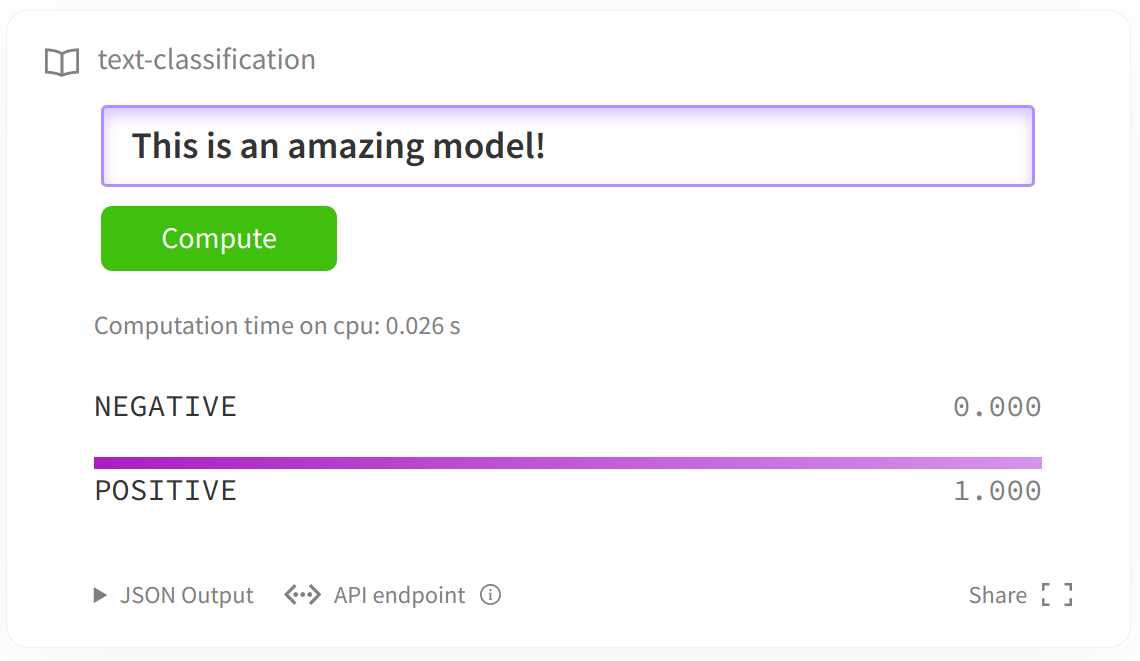

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [1]:
!pip install "sagemaker>=2.48.0" "transformers==4.12.3" "datasets[s3]==1.18.3" --upgrade

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [2]:
!pip install -q transformers torch
# !pip install -q datasets
!pip install -q sentencepiece
# !pip install -q torch

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [3]:
# import nltk
# nltk.download('punkt')

## Development environment 

In [4]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [5]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::641078039118:role/service-role/AmazonSageMaker-ExecutionRole-20220603T174026
sagemaker bucket: sagemaker-us-east-1-641078039118
sagemaker session region: us-east-1


# Preprocessing

We are using the `datasets` library to download and preprocess the `imdb` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [imdb](http://ai.stanford.edu/~amaas/data/sentiment/) dataset consists of 25000 training and 25000 testing highly polar movie reviews.

## Tokenization 

In [6]:
# from datasets import load_dataset
# from transformers import AutoTokenizer

# # tokenizer used in preprocessing
# tokenizer_name = 'distilbert-base-uncased'

# # dataset used
# dataset_name = 'imdb'

# # s3 key prefix for the data
# s3_prefix = 'samples/datasets/imdb'

In [7]:
# load dataset
# dataset = load_dataset(dataset_name)

# # download tokenizer
# tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# # tokenizer helper function
# def tokenize(batch):
#     return tokenizer(batch['text'], padding='max_length', truncation=True)

# # load dataset
# train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
# test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# # tokenize dataset
# train_dataset = train_dataset.map(tokenize, batched=True)
# test_dataset = test_dataset.map(tokenize, batched=True)

# # set format for pytorch
# train_dataset =  train_dataset.rename_column("label", "labels")
# train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
# test_dataset = test_dataset.rename_column("label", "labels")
# test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [8]:
# Tokenizer stuff

## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [9]:
# import botocore
# from datasets.filesystems import S3FileSystem

# s3 = S3FileSystem()  

# # save train_dataset to s3
# training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
# train_dataset.save_to_disk(training_input_path,fs=s3)

# # save test_dataset to s3
# test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
# test_dataset.save_to_disk(test_input_path,fs=s3)


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


## Creating an Estimator and start a training job

In [10]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'model_name':'neuroscience-to-dev-bio'
                 }

In [11]:
huggingface_estimator = HuggingFace(entry_point='neuroscience_to_dev_bio.py',
                            source_dir='./scripts',
                            instance_type='ml.g4dn.16xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.12',
                            pytorch_version='1.9',
                            py_version='py38',
                            hyperparameters = hyperparameters,
                            volume_size=900)

In [12]:
huggingface_estimator.volume_size

900

In [13]:
!ls -a

.		    .sagemaker-jumpstart-tasks-status.json
..		    .yarnrc
.aws		    Untitled.ipynb
.cache		    dld.csv
.canvas		    dld.txt
.config		    neuroscience-to-dev-bio.ipynb
.ipynb_checkpoints  sagemaker-notebook.ipynb
.ipython	    scripts
.jupyter	    test.txt
.local		    train.csv


In [14]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit()

2022-06-05 12:06:39 Starting - Starting the training job...
2022-06-05 12:06:55 Starting - Preparing the instances for trainingProfilerReport-1654430798: InProgress
.........
2022-06-05 12:08:26 Downloading - Downloading input data
2022-06-05 12:08:26 Training - Downloading the training image..........................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-05 12:12:50,216 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-05 12:12:50,235 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-05 12:12:50,241 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-05 12:12:50,654 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
2022-06-05 12:12:53,633 sagemaker-training-toolkit INFO     Invoking user

UnexpectedStatusException: Error for Training job huggingface-pytorch-training-2022-06-05-12-06-38-531: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage ""
Command "/opt/conda/bin/python3.8 neuroscience_to_dev_bio.py --epochs 1 --model_name neuroscience-to-dev-bio", exit code: 1

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [ ]:
predictor = huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

Then, we use the returned predictor object to call the endpoint.

In [ ]:
sentiment_input= {"inputs":"Testing"}

print('Predicting...')
print(predictor.predict(sentiment_input))

Finally, we delete the endpoint again.

In [ ]:
predictor.delete_endpoint()

# Extras

### Estimator Parameters

In [ ]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



In [ ]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

### Attach to old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [ ]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name=''

In [ ]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data